### import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm

import sys
sys.path.append('../../wuchengzhou')
import sagan

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

uniform = np.random.uniform
normal = np.random.normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### def spec_gen functions

In [2]:
def pnormal(mean, stddev):
    while True:
        value = normal(mean, stddev)
        if value >= 0:  # 确保值不为负
            return value

def generate_continuum(wave):
    # Generate random parameters for the power law
    amp1 = 10 * np.random.rand()
    amp2 = np.random.rand()
    alpha = uniform(0, 2)
    stddev = uniform(500, 2500)
    z = uniform(0, 0.01)
    
    # Create the model
    pl_amps = models.PowerLaw1D(amplitude=amp1, x_0=5500, alpha=alpha, fixed={'x_0': True})
    iron = sagan.IronTemplate(amplitude=amp2, stddev=stddev, z=z, name='Fe II')
    model = pl_amps + iron
    flux = model(wave)
    
    # Add noise
    noise = np.random.normal(0, 0.1, wave.size)
    flux += noise
    
    return flux

# narrow Line with 2 components
# Hb:2, oIII:2, narrow: 1, Ha: 2
def generate_spec(wave, arg_dict):

    amp_c0 = arg_dict['line_o3']['amp_c0']
    dv_c = arg_dict['line_o3']['dv_c']
    sigma_c = arg_dict['line_o3']['sigma_c']
    amp_w0 = arg_dict['line_o3']['amp_w0']
    dv_w0 = arg_dict['line_o3']['dv_w0']
    sigma_w0 = arg_dict['line_o3']['sigma_w0']

    line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=amp_c0, amp_c1=0.2, dv_c=dv_c, sigma_c=sigma_c, wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]', amp_w0=amp_w0, dv_w0=dv_w0, sigma_w0=sigma_w0)
    
    def tie_o3(model):
        return model['[O III]'].amp_c0 / 2.98
    line_o3.amp_c1.tied = tie_o3
    
    n_ha = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_ha']['amp_c'], wavec=wave_dict['Halpha'], name=f'narrow {label_dict["Halpha"]}')
    n_hb = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hb']['amp_c'], wavec=wave_dict['Hbeta'], name=f'narrow {label_dict["Hbeta"]}')
    n_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['n_hc']['amp_c'], wavec=wave_dict['Hgamma'], name=f'narrow {label_dict["Hgamma"]}')

    
    b_HeI = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_HeI']['amp_c'], dv_c=arg_dict['b_HeI']['dv_c'], sigma_c=arg_dict['b_HeI']['sigma_c'], wavec=5875.624, name=f'He I 5876')
    
    b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_ha']['amp_c'], dv_c=arg_dict['b_ha']['dv_c'], sigma_c=arg_dict['b_ha']['sigma_c'], wavec=wave_dict['Halpha'], name=label_dict['Halpha'], amp_w0=arg_dict['b_ha']['amp_w0'], sigma_w0=arg_dict['b_ha']['sigma_w0'], dv_w0=arg_dict['b_ha']['dv_w0'])
    b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=arg_dict['b_hb']['amp_c'], dv_c=arg_dict['b_hb']['dv_c'], sigma_c=arg_dict['b_hb']['sigma_c'], wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'], amp_w0=arg_dict['b_hb']['amp_w0'], dv_w0=arg_dict['b_hb']['dv_w0'], sigma_w0=arg_dict['b_hb']['sigma_w0'])
    b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=arg_dict['b_hg']['amp_c'], dv_c=arg_dict['b_hg']['dv_c'], sigma_c=arg_dict['b_hg']['sigma_c'], wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])
    
    def tie_narrow_sigma_c(model):
        return model['[O III]'].sigma_c

    def tie_narrow_dv_c(model):
        return model['[O III]'].dv_c

    for line in [n_ha, n_hb, n_hg]:
        line.sigma_c.tied = tie_narrow_sigma_c
        line.dv_c.tied = tie_narrow_dv_c
    
    line_ha = b_ha + n_ha
    line_hb = b_hb + n_hb
    line_hg = b_hg + n_hg

    # def model
    model = (line_ha + line_hb + line_hg + line_o3 + b_HeI)
    
    # Add Gaussian noise
    noise = np.random.normal(0, 0.015, wave.size)
    
    flux = model(wave) + noise
    
    return flux

### def neural network

In [3]:
class CNN1(nn.Module):
    def __init__(self, input_height=2, input_width=1000, output_dim=27):
        super(CNN1, self).__init__()
        # 输入为2×n的矩阵，假设n=100（可以根据实际情况调整）
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 21), padding=(0, 10))  # 输入通道1，输出通道16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 21), padding=(0, 10))  # 输入通道16，输出通道32
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(1, 21), padding=(0, 10))  # 输入通道32，输出通道64
        self.pool = nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))         # 池化层
        # 计算全连接层的输入维度
        self.fc_input_dim = self._calculate_fc_input_dim(input_height, input_width)
        self.fc1 = nn.Linear(self.fc_input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        # 假设输入x的维度为[batch_size, 1, 2, n]
        
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # 展平操作
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        return x

    def _calculate_fc_input_dim(self, input_height, input_width):
        # 计算卷积层和池化层后的特征图尺寸
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_height, input_width)
            dummy_output = self.pool(F.relu(self.conv3(self.pool(F.relu(self.conv2(self.pool(F.relu(self.conv1(dummy_input)))))))))
            return dummy_output.numel()

### def training process

In [4]:
def calculate_accuracy(model, dataloader):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            # 假设准确率的计算方式为预测值与目标值的均方误差小于某个阈值
            mse = ((outputs - targets) ** 2).mean(dim=1)
            correct = (mse < 0.1).sum().item()  # 阈值可以根据实际情况调整
            total_correct += correct
            total_samples += inputs.size(0)
    accuracy = total_correct / total_samples
    return accuracy

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        # 计算训练集和测试集上的准确率
        train_accuracy = calculate_accuracy(model, train_loader)
        test_accuracy = calculate_accuracy(model, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    return train_losses, train_accuracies, test_accuracies

def plot_training_curve(train_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()
    plt.show()

In [8]:
def generate_data(num_samples=200, input_width=1000):
    X_list = []
    y_list = []
    
    for _ in range(num_samples):
        
        arg_dict_func = {
            'b_ha': {'amp_c':uniform, 'sigma_c':uniform, 'dv_c':normal, 'amp_w0':uniform, 'dv_w0':normal, 'sigma_w0':pnormal}, 
            'b_hb': {'amp_c':uniform, 'sigma_c':pnormal, 'dv_c':normal, 'amp_w0':uniform, 'dv_w0':normal, 'sigma_w0':pnormal}, 
            'b_hg': {'amp_c':uniform, 'sigma_c':pnormal, 'dv_c':normal}, 
            'n_ha':{'amp_c':pnormal}, 
            'n_hb':{'amp_c':pnormal}, 
            'n_hc':{'amp_c':pnormal}, 
            'line_o3': {'amp_c0':pnormal, 'sigma_c':pnormal, 'dv_c':normal, 'amp_w0':uniform, 'dv_w0':normal, 'sigma_w0':pnormal}, 
            'b_HeI': {'amp_c':pnormal, 'sigma_c':uniform, 'dv_c':normal}
        }
        
        arg_dict_range = {
            'b_ha': {'amp_c':(1.5, 2.5), 'sigma_c':(1200, 1600), 'dv_c':(0, 75), 'amp_w0':(0.05, 0.6), 'dv_w0':(0, 400), 'sigma_w0':(5000, 400)}, 
            'b_hb': {'amp_c':(0.7, 1.7), 'sigma_c':(1500, 200), 'dv_c':(0, 75), 'amp_w0':(0.05, 0.3), 'dv_w0':(0, 100), 'sigma_w0':(5000, 450)}, 
            'b_hg': {'amp_c':(0.4, 0.9), 'sigma_c':(1500, 200), 'dv_c':(0, 75)}, 
            'n_ha':{'amp_c':(0.1, 0.05)}, 
            'n_hb':{'amp_c':(0.1, 0.05)}, 
            'n_hc':{'amp_c':(0.1, 0.05)}, 
            'line_o3': {'amp_c0':(1, 0.5), 'sigma_c':(500, 200), 'dv_c':(0, 75), 'amp_w0':(0.1, 0.5), 'dv_w0':(-100, 100), 'sigma_w0':(1700, 400)}, 
            'b_HeI': {'amp_c':(0.1, 0.08), 'sigma_c':(1400, 1800), 'dv_c':(0, 75)}
        }
        
        arg_dict = {key: {param: arg_dict_func[key][param](*arg_dict_range[key][param]) for param in arg_dict_func[key]} for key in arg_dict_func}
        
        wave = np.linspace(4150, 7000, input_width)
        flux = generate_spec(wave, arg_dict=arg_dict)
        
        data = np.stack((wave, flux), axis=0)
        X_list.append(torch.tensor(data, dtype=torch.float32).view(1, 2, input_width))
        arg_list = [value for line in arg_dict.values() for value in line.values()]
        y_list.append(torch.tensor(arg_list, dtype=torch.float32))
    
    X = torch.cat(X_list, dim=0).reshape(num_samples, 1, 2, input_width)
    y = torch.stack(y_list)

    return X, y

if __name__ == "__main__":
    X, y = generate_data(1, 1000)
    print(y)
    print(X.shape)
    print(y.shape)


tensor([[ 2.1688e+00,  1.5570e+03, -1.1820e+02,  5.9596e-01,  3.0189e+02,
          4.9668e+03,  1.4125e+00,  1.5397e+03, -1.4829e+02,  2.0000e-01,
          4.2984e+01,  5.0560e+03,  4.2642e-01,  1.3073e+03, -3.8254e+01,
          7.9363e-02,  4.1200e-03,  1.0961e-02,  3.2933e-01,  3.6226e+02,
         -6.1885e+01,  2.5932e-01,  2.5017e+01,  1.7145e+03,  2.4046e-02,
          1.7950e+03,  4.7650e+01]])
torch.Size([1, 1, 2, 1000])
torch.Size([1, 27])


### training

Epoch 2/200:  39%|███▊      | 29/75 [00:00<00:00, 282.29it/s]

Epoch [1/200], Loss: 2330711.1167, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 3/200:  39%|███▊      | 29/75 [00:00<00:00, 284.78it/s]

Epoch [2/200], Loss: 2328532.7633, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 4/200:  41%|████▏     | 31/75 [00:00<00:00, 284.16it/s]

Epoch [3/200], Loss: 2323502.7800, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 5/200:  39%|███▊      | 29/75 [00:00<00:00, 276.62it/s]

Epoch [4/200], Loss: 2315684.5567, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 6/200:  37%|███▋      | 28/75 [00:00<00:00, 262.38it/s]

Epoch [5/200], Loss: 2305403.6533, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 7/200:  39%|███▊      | 29/75 [00:00<00:00, 269.95it/s]

Epoch [6/200], Loss: 2292617.6933, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 8/200:  39%|███▊      | 29/75 [00:00<00:00, 265.00it/s]

Epoch [7/200], Loss: 2277462.5233, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 9/200:  76%|███████▌  | 57/75 [00:00<00:00, 277.71it/s]

Epoch [8/200], Loss: 2260181.1267, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 10/200:  37%|███▋      | 28/75 [00:00<00:00, 277.52it/s]

Epoch [9/200], Loss: 2240774.6333, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 11/200:  37%|███▋      | 28/75 [00:00<00:00, 279.33it/s]

Epoch [10/200], Loss: 2219421.1300, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 12/200:  40%|████      | 30/75 [00:00<00:00, 272.95it/s]

Epoch [11/200], Loss: 2196185.7033, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 13/200:  39%|███▊      | 29/75 [00:00<00:00, 285.65it/s]

Epoch [12/200], Loss: 2171279.0117, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 14/200:  75%|███████▍  | 56/75 [00:00<00:00, 271.16it/s]

Epoch [13/200], Loss: 2144730.2117, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 15/200:  36%|███▌      | 27/75 [00:00<00:00, 264.46it/s]

Epoch [14/200], Loss: 2116981.5983, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 16/200:  40%|████      | 30/75 [00:00<00:00, 288.40it/s]

Epoch [15/200], Loss: 2087628.4883, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 17/200:  77%|███████▋  | 58/75 [00:00<00:00, 275.60it/s]

Epoch [16/200], Loss: 2057171.8600, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 18/200:  37%|███▋      | 28/75 [00:00<00:00, 274.06it/s]

Epoch [17/200], Loss: 2025665.1767, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 19/200:  40%|████      | 30/75 [00:00<00:00, 288.93it/s]

Epoch [18/200], Loss: 1993226.7067, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 20/200:  37%|███▋      | 28/75 [00:00<00:00, 274.69it/s]

Epoch [19/200], Loss: 1959788.3017, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 21/200:  39%|███▊      | 29/75 [00:00<00:00, 287.98it/s]

Epoch [20/200], Loss: 1925620.8933, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 22/200:  76%|███████▌  | 57/75 [00:00<00:00, 280.52it/s]

Epoch [21/200], Loss: 1890896.1650, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 23/200:  36%|███▌      | 27/75 [00:00<00:00, 267.96it/s]

Epoch [22/200], Loss: 1855431.8767, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 24/200:  39%|███▊      | 29/75 [00:00<00:00, 283.13it/s]

Epoch [23/200], Loss: 1819474.2183, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 25/200:  40%|████      | 30/75 [00:00<00:00, 292.60it/s]

Epoch [24/200], Loss: 1783171.4650, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 26/200:  40%|████      | 30/75 [00:00<00:00, 279.81it/s]

Epoch [25/200], Loss: 1746669.9667, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 27/200:  40%|████      | 30/75 [00:00<00:00, 280.57it/s]

Epoch [26/200], Loss: 1709889.2733, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 28/200:  40%|████      | 30/75 [00:00<00:00, 282.48it/s]

Epoch [27/200], Loss: 1672982.7817, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 29/200:  37%|███▋      | 28/75 [00:00<00:00, 279.68it/s]

Epoch [28/200], Loss: 1635957.9017, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 30/200:  39%|███▊      | 29/75 [00:00<00:00, 289.64it/s]

Epoch [29/200], Loss: 1598900.5750, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 31/200:  77%|███████▋  | 58/75 [00:00<00:00, 284.00it/s]

Epoch [30/200], Loss: 1561930.2067, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 32/200:  39%|███▊      | 29/75 [00:00<00:00, 284.47it/s]

Epoch [31/200], Loss: 1525060.7733, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 33/200:  39%|███▊      | 29/75 [00:00<00:00, 284.73it/s]

Epoch [32/200], Loss: 1488318.9300, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 34/200:  63%|██████▎   | 47/75 [00:00<00:00, 234.39it/s]

Epoch [33/200], Loss: 1451912.6117, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 35/200:  76%|███████▌  | 57/75 [00:00<00:00, 271.74it/s]

Epoch [34/200], Loss: 1415699.0000, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 36/200:  39%|███▊      | 29/75 [00:00<00:00, 285.95it/s]

Epoch [35/200], Loss: 1379793.6933, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 37/200:  75%|███████▍  | 56/75 [00:00<00:00, 271.49it/s]

Epoch [36/200], Loss: 1344295.7183, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 38/200:  41%|████▏     | 31/75 [00:00<00:00, 283.18it/s]

Epoch [37/200], Loss: 1309090.9083, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 39/200:  43%|████▎     | 32/75 [00:00<00:00, 292.52it/s]

Epoch [38/200], Loss: 1274400.2217, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 40/200:  40%|████      | 30/75 [00:00<00:00, 293.64it/s]

Epoch [39/200], Loss: 1240142.6733, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 41/200:  77%|███████▋  | 58/75 [00:00<00:00, 288.94it/s]

Epoch [40/200], Loss: 1206588.3383, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 42/200:  79%|███████▊  | 59/75 [00:00<00:00, 288.40it/s]

Epoch [41/200], Loss: 1173352.0500, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 43/200:  80%|████████  | 60/75 [00:00<00:00, 290.34it/s]

Epoch [42/200], Loss: 1140808.2583, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 44/200:  37%|███▋      | 28/75 [00:00<00:00, 276.63it/s]

Epoch [43/200], Loss: 1108924.1800, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 45/200:  40%|████      | 30/75 [00:00<00:00, 276.82it/s]

Epoch [44/200], Loss: 1077518.5808, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 46/200:  39%|███▊      | 29/75 [00:00<00:00, 280.51it/s]

Epoch [45/200], Loss: 1046902.8233, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 47/200:  73%|███████▎  | 55/75 [00:00<00:00, 269.76it/s]

Epoch [46/200], Loss: 1016731.8400, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 48/200:  37%|███▋      | 28/75 [00:00<00:00, 279.77it/s]

Epoch [47/200], Loss: 987340.4708, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 49/200:  72%|███████▏  | 54/75 [00:00<00:00, 256.45it/s]

Epoch [48/200], Loss: 958565.2617, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 50/200:  41%|████▏     | 31/75 [00:00<00:00, 292.69it/s]

Epoch [49/200], Loss: 930370.5792, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 51/200:  39%|███▊      | 29/75 [00:00<00:00, 287.53it/s]

Epoch [50/200], Loss: 902937.1742, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 52/200:  40%|████      | 30/75 [00:00<00:00, 291.85it/s]

Epoch [51/200], Loss: 876068.3592, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 53/200:  36%|███▌      | 27/75 [00:00<00:00, 267.31it/s]

Epoch [52/200], Loss: 849687.1533, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 54/200:  39%|███▊      | 29/75 [00:00<00:00, 279.27it/s]

Epoch [53/200], Loss: 823897.7658, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 55/200:  40%|████      | 30/75 [00:00<00:00, 290.70it/s]

Epoch [54/200], Loss: 798710.5250, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 56/200:  39%|███▊      | 29/75 [00:00<00:00, 287.60it/s]

Epoch [55/200], Loss: 774027.7575, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 57/200:  39%|███▊      | 29/75 [00:00<00:00, 289.21it/s]

Epoch [56/200], Loss: 749849.7358, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 58/200:  41%|████▏     | 31/75 [00:00<00:00, 293.22it/s]

Epoch [57/200], Loss: 726080.6208, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 59/200:  40%|████      | 30/75 [00:00<00:00, 297.41it/s]

Epoch [58/200], Loss: 702732.2750, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 60/200:  77%|███████▋  | 58/75 [00:00<00:00, 281.81it/s]

Epoch [59/200], Loss: 679680.1158, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 61/200:  40%|████      | 30/75 [00:00<00:00, 291.22it/s]

Epoch [60/200], Loss: 657080.1342, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 62/200:  39%|███▊      | 29/75 [00:00<00:00, 287.02it/s]

Epoch [61/200], Loss: 634832.7450, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 63/200:  40%|████      | 30/75 [00:00<00:00, 289.12it/s]

Epoch [62/200], Loss: 612839.0742, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 64/200:  41%|████▏     | 31/75 [00:00<00:00, 289.19it/s]

Epoch [63/200], Loss: 591958.9442, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 65/200:  40%|████      | 30/75 [00:00<00:00, 287.82it/s]

Epoch [64/200], Loss: 569776.8342, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 66/200:  39%|███▊      | 29/75 [00:00<00:00, 286.68it/s]

Epoch [65/200], Loss: 548536.7425, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 67/200:  40%|████      | 30/75 [00:00<00:00, 291.02it/s]

Epoch [66/200], Loss: 527557.6271, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 68/200:  39%|███▊      | 29/75 [00:00<00:00, 289.56it/s]

Epoch [67/200], Loss: 507038.2758, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 69/200:  37%|███▋      | 28/75 [00:00<00:00, 279.24it/s]

Epoch [68/200], Loss: 486669.7967, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 70/200:  39%|███▊      | 29/75 [00:00<00:00, 281.63it/s]

Epoch [69/200], Loss: 466656.6717, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 71/200:  39%|███▊      | 29/75 [00:00<00:00, 289.74it/s]

Epoch [70/200], Loss: 446770.9750, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 72/200:  79%|███████▊  | 59/75 [00:00<00:00, 285.44it/s]

Epoch [71/200], Loss: 427535.8904, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 73/200:  39%|███▊      | 29/75 [00:00<00:00, 279.64it/s]

Epoch [72/200], Loss: 408253.9167, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 74/200:  40%|████      | 30/75 [00:00<00:00, 282.35it/s]

Epoch [73/200], Loss: 389564.7554, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 75/200:  36%|███▌      | 27/75 [00:00<00:00, 260.16it/s]

Epoch [74/200], Loss: 371191.6192, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 76/200:  40%|████      | 30/75 [00:00<00:00, 283.06it/s]

Epoch [75/200], Loss: 353143.7812, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 77/200:  77%|███████▋  | 58/75 [00:00<00:00, 287.82it/s]

Epoch [76/200], Loss: 335492.9888, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 78/200:  40%|████      | 30/75 [00:00<00:00, 286.84it/s]

Epoch [77/200], Loss: 318365.6046, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 79/200:  40%|████      | 30/75 [00:00<00:00, 292.48it/s]

Epoch [78/200], Loss: 301852.3775, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 80/200:  79%|███████▊  | 59/75 [00:00<00:00, 293.31it/s]

Epoch [79/200], Loss: 285565.0321, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 81/200:  79%|███████▊  | 59/75 [00:00<00:00, 292.27it/s]

Epoch [80/200], Loss: 269702.2783, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 82/200:  33%|███▎      | 25/75 [00:00<00:00, 247.23it/s]

Epoch [81/200], Loss: 254526.5423, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 83/200:  79%|███████▊  | 59/75 [00:00<00:00, 287.56it/s]

Epoch [82/200], Loss: 239594.2056, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 84/200:  39%|███▊      | 29/75 [00:00<00:00, 287.77it/s]

Epoch [83/200], Loss: 225252.3915, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 85/200:  80%|████████  | 60/75 [00:00<00:00, 290.04it/s]

Epoch [84/200], Loss: 211379.1967, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 86/200:  39%|███▊      | 29/75 [00:00<00:00, 286.48it/s]

Epoch [85/200], Loss: 198224.2044, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 87/200:  40%|████      | 30/75 [00:00<00:00, 297.62it/s]

Epoch [86/200], Loss: 185444.5602, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 88/200:  39%|███▊      | 29/75 [00:00<00:00, 279.93it/s]

Epoch [87/200], Loss: 173193.8052, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 89/200:  77%|███████▋  | 58/75 [00:00<00:00, 278.99it/s]

Epoch [88/200], Loss: 161479.2694, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 90/200:  40%|████      | 30/75 [00:00<00:00, 288.19it/s]

Epoch [89/200], Loss: 150361.6927, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 91/200:  80%|████████  | 60/75 [00:00<00:00, 288.07it/s]

Epoch [90/200], Loss: 139695.3326, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 92/200:  40%|████      | 30/75 [00:00<00:00, 291.33it/s]

Epoch [91/200], Loss: 129650.9394, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 93/200:  77%|███████▋  | 58/75 [00:00<00:00, 285.14it/s]

Epoch [92/200], Loss: 120040.9074, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 94/200:  76%|███████▌  | 57/75 [00:00<00:00, 281.81it/s]

Epoch [93/200], Loss: 110998.4484, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 95/200:  39%|███▊      | 29/75 [00:00<00:00, 289.68it/s]

Epoch [94/200], Loss: 102544.7873, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 96/200:  77%|███████▋  | 58/75 [00:00<00:00, 280.48it/s]

Epoch [95/200], Loss: 94470.1989, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 97/200:  73%|███████▎  | 55/75 [00:00<00:00, 268.50it/s]

Epoch [96/200], Loss: 86906.8791, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 98/200:  40%|████      | 30/75 [00:00<00:00, 284.40it/s]

Epoch [97/200], Loss: 79837.9654, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 99/200:  40%|████      | 30/75 [00:00<00:00, 290.44it/s]

Epoch [98/200], Loss: 73401.5917, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 100/200:  39%|███▊      | 29/75 [00:00<00:00, 283.88it/s]

Epoch [99/200], Loss: 69800.5414, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 101/200:  39%|███▊      | 29/75 [00:00<00:00, 288.35it/s]

Epoch [100/200], Loss: 62796.0693, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 102/200:  77%|███████▋  | 58/75 [00:00<00:00, 278.48it/s]

Epoch [101/200], Loss: 56819.2619, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 103/200:  39%|███▊      | 29/75 [00:00<00:00, 281.87it/s]

Epoch [102/200], Loss: 51937.9253, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 104/200:  39%|███▊      | 29/75 [00:00<00:00, 283.89it/s]

Epoch [103/200], Loss: 47499.0472, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 105/200:  39%|███▊      | 29/75 [00:00<00:00, 275.48it/s]

Epoch [104/200], Loss: 43457.4938, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 106/200:  79%|███████▊  | 59/75 [00:00<00:00, 284.96it/s]

Epoch [105/200], Loss: 39894.1770, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 107/200:  79%|███████▊  | 59/75 [00:00<00:00, 283.52it/s]

Epoch [106/200], Loss: 36627.8134, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 108/200:  77%|███████▋  | 58/75 [00:00<00:00, 280.91it/s]

Epoch [107/200], Loss: 33590.2151, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 109/200:  40%|████      | 30/75 [00:00<00:00, 290.72it/s]

Epoch [108/200], Loss: 31612.9121, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 110/200:  39%|███▊      | 29/75 [00:00<00:00, 282.84it/s]

Epoch [109/200], Loss: 28892.0126, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 111/200:  39%|███▊      | 29/75 [00:00<00:00, 274.17it/s]

Epoch [110/200], Loss: 26901.5578, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 112/200:  40%|████      | 30/75 [00:00<00:00, 288.90it/s]

Epoch [111/200], Loss: 24996.9581, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 113/200:  40%|████      | 30/75 [00:00<00:00, 288.24it/s]

Epoch [112/200], Loss: 23516.3706, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 114/200:  40%|████      | 30/75 [00:00<00:00, 289.06it/s]

Epoch [113/200], Loss: 22065.2693, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 115/200:  79%|███████▊  | 59/75 [00:00<00:00, 290.43it/s]

Epoch [114/200], Loss: 20842.6026, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 116/200:  39%|███▊      | 29/75 [00:00<00:00, 281.39it/s]

Epoch [115/200], Loss: 20036.4458, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 117/200:  39%|███▊      | 29/75 [00:00<00:00, 286.80it/s]

Epoch [116/200], Loss: 19097.8990, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 118/200:  39%|███▊      | 29/75 [00:00<00:00, 287.36it/s]

Epoch [117/200], Loss: 18169.6065, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 119/200:  36%|███▌      | 27/75 [00:00<00:00, 263.59it/s]

Epoch [118/200], Loss: 17662.8859, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 120/200:  75%|███████▍  | 56/75 [00:00<00:00, 272.86it/s]

Epoch [119/200], Loss: 17126.2229, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 121/200:  79%|███████▊  | 59/75 [00:00<00:00, 290.47it/s]

Epoch [120/200], Loss: 17721.3540, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 122/200:  41%|████▏     | 31/75 [00:00<00:00, 290.22it/s]

Epoch [121/200], Loss: 20884.8117, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 123/200:  79%|███████▊  | 59/75 [00:00<00:00, 286.83it/s]

Epoch [122/200], Loss: 18032.4377, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 124/200:  76%|███████▌  | 57/75 [00:00<00:00, 284.40it/s]

Epoch [123/200], Loss: 16868.7125, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 125/200:  39%|███▊      | 29/75 [00:00<00:00, 288.02it/s]

Epoch [124/200], Loss: 16372.0778, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 126/200:  40%|████      | 30/75 [00:00<00:00, 283.10it/s]

Epoch [125/200], Loss: 16064.5034, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 127/200:  40%|████      | 30/75 [00:00<00:00, 288.23it/s]

Epoch [126/200], Loss: 15895.9382, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 128/200:  40%|████      | 30/75 [00:00<00:00, 291.15it/s]

Epoch [127/200], Loss: 15651.6686, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 129/200:  39%|███▊      | 29/75 [00:00<00:00, 280.21it/s]

Epoch [128/200], Loss: 15717.9594, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 130/200:  37%|███▋      | 28/75 [00:00<00:00, 279.40it/s]

Epoch [129/200], Loss: 15550.0809, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 131/200:  40%|████      | 30/75 [00:00<00:00, 287.76it/s]

Epoch [130/200], Loss: 15385.2612, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 132/200:  39%|███▊      | 29/75 [00:00<00:00, 288.89it/s]

Epoch [131/200], Loss: 15383.2164, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 133/200:  37%|███▋      | 28/75 [00:00<00:00, 277.61it/s]

Epoch [132/200], Loss: 15368.5578, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 134/200:  40%|████      | 30/75 [00:00<00:00, 289.98it/s]

Epoch [133/200], Loss: 15277.1661, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 135/200:  39%|███▊      | 29/75 [00:00<00:00, 279.31it/s]

Epoch [134/200], Loss: 15311.0700, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 136/200:  39%|███▊      | 29/75 [00:00<00:00, 287.05it/s]

Epoch [135/200], Loss: 15267.2004, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 137/200:  39%|███▊      | 29/75 [00:00<00:00, 286.38it/s]

Epoch [136/200], Loss: 15100.8478, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 138/200:  39%|███▊      | 29/75 [00:00<00:00, 281.68it/s]

Epoch [137/200], Loss: 15318.3082, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 139/200:  39%|███▊      | 29/75 [00:00<00:00, 282.60it/s]

Epoch [138/200], Loss: 18163.3014, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 140/200:  39%|███▊      | 29/75 [00:00<00:00, 286.69it/s]

Epoch [139/200], Loss: 18783.0408, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 141/200:  73%|███████▎  | 55/75 [00:00<00:00, 271.96it/s]

Epoch [140/200], Loss: 16132.0104, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 142/200:  36%|███▌      | 27/75 [00:00<00:00, 268.03it/s]

Epoch [141/200], Loss: 15589.4771, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 143/200:  39%|███▊      | 29/75 [00:00<00:00, 289.51it/s]

Epoch [142/200], Loss: 15355.4156, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 144/200:  39%|███▊      | 29/75 [00:00<00:00, 282.96it/s]

Epoch [143/200], Loss: 15148.6798, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 145/200:  39%|███▊      | 29/75 [00:00<00:00, 282.56it/s]

Epoch [144/200], Loss: 15224.5604, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 146/200:  40%|████      | 30/75 [00:00<00:00, 291.70it/s]

Epoch [145/200], Loss: 14974.7558, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 147/200:  39%|███▊      | 29/75 [00:00<00:00, 286.69it/s]

Epoch [146/200], Loss: 14788.6356, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 148/200:  39%|███▊      | 29/75 [00:00<00:00, 284.90it/s]

Epoch [147/200], Loss: 14803.7879, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 149/200:  39%|███▊      | 29/75 [00:00<00:00, 285.80it/s]

Epoch [148/200], Loss: 17351.1995, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 150/200:  39%|███▊      | 29/75 [00:00<00:00, 283.58it/s]

Epoch [149/200], Loss: 15128.0419, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 151/200:  77%|███████▋  | 58/75 [00:00<00:00, 285.41it/s]

Epoch [150/200], Loss: 14703.9407, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 152/200:  39%|███▊      | 29/75 [00:00<00:00, 289.81it/s]

Epoch [151/200], Loss: 14596.1694, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 153/200:  39%|███▊      | 29/75 [00:00<00:00, 284.50it/s]

Epoch [152/200], Loss: 14484.2563, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 154/200:  39%|███▊      | 29/75 [00:00<00:00, 283.29it/s]

Epoch [153/200], Loss: 14290.3153, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 155/200:  77%|███████▋  | 58/75 [00:00<00:00, 282.69it/s]

Epoch [154/200], Loss: 14252.0930, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 156/200:  77%|███████▋  | 58/75 [00:00<00:00, 282.10it/s]

Epoch [155/200], Loss: 14308.2556, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 157/200:  76%|███████▌  | 57/75 [00:00<00:00, 273.99it/s]

Epoch [156/200], Loss: 14118.5862, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 158/200:  39%|███▊      | 29/75 [00:00<00:00, 284.62it/s]

Epoch [157/200], Loss: 13927.4419, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 159/200:  39%|███▊      | 29/75 [00:00<00:00, 277.29it/s]

Epoch [158/200], Loss: 14029.3905, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 160/200:  76%|███████▌  | 57/75 [00:00<00:00, 278.81it/s]

Epoch [159/200], Loss: 13949.6756, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 161/200:  37%|███▋      | 28/75 [00:00<00:00, 276.66it/s]

Epoch [160/200], Loss: 13868.8482, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 162/200:  33%|███▎      | 25/75 [00:00<00:00, 249.03it/s]

Epoch [161/200], Loss: 13606.7751, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 163/200:  35%|███▍      | 26/75 [00:00<00:00, 257.78it/s]

Epoch [162/200], Loss: 13528.5854, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 164/200:  75%|███████▍  | 56/75 [00:00<00:00, 273.39it/s]

Epoch [163/200], Loss: 13509.8012, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 165/200:  37%|███▋      | 28/75 [00:00<00:00, 271.56it/s]

Epoch [164/200], Loss: 13261.9057, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 166/200:  71%|███████   | 53/75 [00:00<00:00, 267.89it/s]

Epoch [165/200], Loss: 13248.6186, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 167/200:  65%|██████▌   | 49/75 [00:00<00:00, 241.60it/s]

Epoch [166/200], Loss: 13108.0043, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 168/200:  36%|███▌      | 27/75 [00:00<00:00, 269.79it/s]

Epoch [167/200], Loss: 13004.6751, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 169/200:  36%|███▌      | 27/75 [00:00<00:00, 269.45it/s]

Epoch [168/200], Loss: 12700.3717, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 170/200:  36%|███▌      | 27/75 [00:00<00:00, 264.34it/s]

Epoch [169/200], Loss: 12573.9138, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 171/200:  75%|███████▍  | 56/75 [00:00<00:00, 273.62it/s]

Epoch [170/200], Loss: 12361.0734, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 172/200:  76%|███████▌  | 57/75 [00:00<00:00, 277.19it/s]

Epoch [171/200], Loss: 12536.6068, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 173/200:  37%|███▋      | 28/75 [00:00<00:00, 276.63it/s]

Epoch [172/200], Loss: 14902.9464, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 174/200:  39%|███▊      | 29/75 [00:00<00:00, 281.34it/s]

Epoch [173/200], Loss: 18939.5781, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 175/200:  40%|████      | 30/75 [00:00<00:00, 291.27it/s]

Epoch [174/200], Loss: 15557.5459, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 176/200:  37%|███▋      | 28/75 [00:00<00:00, 262.09it/s]

Epoch [175/200], Loss: 14323.2736, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 177/200:  36%|███▌      | 27/75 [00:00<00:00, 264.42it/s]

Epoch [176/200], Loss: 13577.2965, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 178/200:  76%|███████▌  | 57/75 [00:00<00:00, 273.91it/s]

Epoch [177/200], Loss: 13072.6405, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 179/200:  73%|███████▎  | 55/75 [00:00<00:00, 269.25it/s]

Epoch [178/200], Loss: 13140.7767, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 180/200:  36%|███▌      | 27/75 [00:00<00:00, 266.94it/s]

Epoch [179/200], Loss: 12551.5739, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 181/200:  36%|███▌      | 27/75 [00:00<00:00, 263.25it/s]

Epoch [180/200], Loss: 11541.4936, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 182/200:  75%|███████▍  | 56/75 [00:00<00:00, 270.48it/s]

Epoch [181/200], Loss: 11577.3929, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 183/200:  37%|███▋      | 28/75 [00:00<00:00, 274.11it/s]

Epoch [182/200], Loss: 10685.2417, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 184/200:  72%|███████▏  | 54/75 [00:00<00:00, 267.02it/s]

Epoch [183/200], Loss: 10130.8187, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 185/200:  76%|███████▌  | 57/75 [00:00<00:00, 281.70it/s]

Epoch [184/200], Loss: 9875.2166, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 186/200:  37%|███▋      | 28/75 [00:00<00:00, 272.58it/s]

Epoch [185/200], Loss: 9715.2015, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 187/200:  39%|███▊      | 29/75 [00:00<00:00, 280.11it/s]

Epoch [186/200], Loss: 9398.0542, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 188/200:  77%|███████▋  | 58/75 [00:00<00:00, 288.90it/s]

Epoch [187/200], Loss: 9226.2468, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 189/200:  39%|███▊      | 29/75 [00:00<00:00, 287.01it/s]

Epoch [188/200], Loss: 9038.3417, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 190/200:  39%|███▊      | 29/75 [00:00<00:00, 281.60it/s]

Epoch [189/200], Loss: 9001.4913, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 191/200:  39%|███▊      | 29/75 [00:00<00:00, 286.38it/s]

Epoch [190/200], Loss: 8705.1010, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 192/200:  76%|███████▌  | 57/75 [00:00<00:00, 278.81it/s]

Epoch [191/200], Loss: 8795.6658, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 193/200:  79%|███████▊  | 59/75 [00:00<00:00, 284.25it/s]

Epoch [192/200], Loss: 8546.0538, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 194/200:  43%|████▎     | 32/75 [00:00<00:00, 292.09it/s]

Epoch [193/200], Loss: 8496.0557, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 195/200:  77%|███████▋  | 58/75 [00:00<00:00, 289.88it/s]

Epoch [194/200], Loss: 8478.0845, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 196/200:  40%|████      | 30/75 [00:00<00:00, 291.14it/s]

Epoch [195/200], Loss: 8361.8285, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 197/200:  79%|███████▊  | 59/75 [00:00<00:00, 288.77it/s]

Epoch [196/200], Loss: 8176.0136, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 198/200:  40%|████      | 30/75 [00:00<00:00, 291.35it/s]

Epoch [197/200], Loss: 8106.1257, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 199/200:  40%|████      | 30/75 [00:00<00:00, 294.32it/s]

Epoch [198/200], Loss: 8082.3326, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 200/200:  39%|███▊      | 29/75 [00:00<00:00, 289.34it/s]

Epoch [199/200], Loss: 8041.2825, Train Accuracy: 0.0000, Test Accuracy: 0.0000


Epoch 200/200: 100%|██████████| 75/75 [00:00<00:00, 287.20it/s]


Epoch [200/200], Loss: 8081.4421, Train Accuracy: 0.0000, Test Accuracy: 0.0000


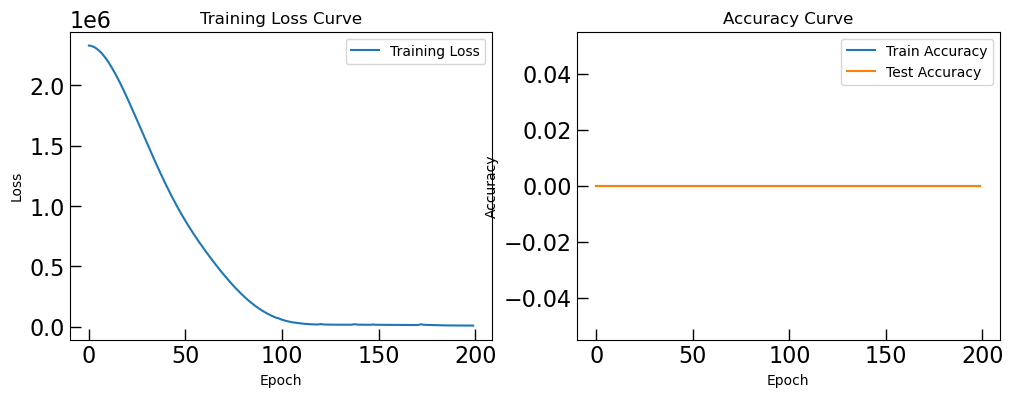

Model saved to ./model/cnn1.pth


In [6]:
if __name__ == "__main__":
    # 超参数
    input_height = 2
    input_width = 1000
    output_dim = 27
    num_samples = 3000
    batch_size = 32
    num_epochs = 200
    learning_rate = 0.001

    X, y = generate_data(num_samples, input_width)
    dataset = TensorDataset(X.to(device), y.to(device))
    train_size = int(0.8 * num_samples)
    test_size = num_samples - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 初始化模型、损失函数和优化器
    model = CNN1(input_height, input_width, output_dim).to(device)
    criterion = nn.MSELoss()  # 均方误差损失函数
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 训练模型
    train_losses, train_accuracies, test_accuracies = train_model(model, train_loader, test_loader, criterion,
                                                                  optimizer, num_epochs)

    # 绘制训练过程
    plot_training_curve(train_losses, train_accuracies, test_accuracies)

    # 保存模型
    torch.save(model.state_dict(), "./model/cnn1.pth")
    print("Model saved to ./model/cnn1.pth")

    # 加载模型并测试
    model.load_state_dict(torch.load("./model/cnn1.pth"))
    test_accuracy = calculate_accuracy(model, test_loader)